In [1]:
import pandas as pd
from scipy.fft import fft
import numpy as np
import math

In [2]:
class PhysicochemicalEncoder:

    def __init__(self,
                 dataset=None,
                 sep_dataset=",",
                 property_encoder="Group_0",
                 dataset_encoder=None,
                 name_column_seq="sequence",
                 columns_to_ignore=[]):

        self.dataset = dataset
        self.sep_dataset = sep_dataset

        self.property_encoder = property_encoder
        self.dataset_encoder = dataset_encoder
        self.name_column_seq = name_column_seq
        self.columns_to_ignore = columns_to_ignore

        self.possible_residues = [
            'A',
            'C',
            'D',
            'E',
            'F',
            'G',
            'H',
            'I',
            'N',
            'K',
            'L',
            'M',
            'P',
            'Q',
            'R',
            'S',
            'T',
            'V',
            'W',
            'Y'
        ]

        self.df_data_encoded = None

        self.status = False
        self.message= ""

    def run_process(self):
        self.__make_validations()

        if self.status == True:
            self.zero_padding = self.__check_max_size()
            self.__encoding_dataset()
            self.message = "ENCODING OK"
        
    def __check_columns_in_df(
            self,
            check_columns=None,
            columns_in_df=None):

        response_check = True

        for colum in check_columns:
            if colum not in columns_in_df:
                response_check=False
                break
        
        return response_check
    
    def __make_validations(self):

        # read the dataset with encoders
        self.dataset_encoder.index = self.dataset_encoder['residue']
        
        # check input dataset
        if self.name_column_seq in self.dataset.columns:
            
            if isinstance(self.columns_to_ignore, list):

                if len(self.columns_to_ignore)>0:
                    
                    response_check = self.__check_columns_in_df(
                        columns_in_df=self.dataset.columns.values,
                        check_columns=self.columns_to_ignore
                    )
                    if response_check == True:
                        self.status=True
                    else:
                        self.message = "ERROR: IGNORE COLUMNS NOT IN DATASET COLUMNS"   
                else:
                    pass
            else:
                self.message = "ERROR: THE ATTRIBUTE columns_to_ignore MUST BE A LIST"
        else:
            self.message = "ERROR: COLUMN TO USE AS SEQUENCE IS NOT IN DATASET COLUMNS"    

    def __check_residues(self, residue):
        if residue in self.possible_residues:
            return True
        else:
            return False

    def __encoding_residue(self, residue):

        if self.__check_residues(residue):
            return self.dataset_encoder[self.property_encoder][residue]
        else:
            return False

    def __check_max_size(self):
        size_list = [len(seq) for seq in self.dataset[self.name_column_seq]]
        return max(size_list)

    def __encoding_sequence(self, sequence):

        sequence = sequence.upper()
        sequence_encoding = []

        for i in range(len(sequence)):
            residue = sequence[i]
            response_encoding = self.__encoding_residue(residue)
            if response_encoding != False:
                sequence_encoding.append(response_encoding)

        # complete zero padding
        for k in range(len(sequence_encoding), self.zero_padding):
            sequence_encoding.append(0)

        return sequence_encoding

    def __encoding_dataset(self):

        #print("Start encoding process")
        if len(self.columns_to_ignore)>0:
            df_columns_ignore = self.dataset[self.columns_to_ignore]
            dataset_to_encode = self.dataset.drop(columns=self.columns_to_ignore)
        else:
            df_columns_ignore=None
            dataset_to_encode = self.dataset

        print("Encoding and Processing results")

        matrix_data = []
        for index in dataset_to_encode.index:
            sequence_encoder = self.__encoding_sequence(sequence=dataset_to_encode[self.name_column_seq][index])
            matrix_data.append(sequence_encoder)

        print("Creating dataset")
        header = ['p_{}'.format(i) for i in range(len(matrix_data[0]))]
        print("Export dataset")

        self.df_data_encoded = pd.DataFrame(matrix_data, columns=header)

        if len(self.columns_to_ignore)>0:
            self.df_data_encoded = pd.concat([self.df_data_encoded, df_columns_ignore], axis=1)

In [ ]:
class FFTTransform:

    def __init__(
            self,
            dataset=None,
            size_data=None,
            columns_to_ignore=[]):
        
        self.size_data = size_data
        self.dataset = dataset
        self.columns_to_ignore = columns_to_ignore

        self.init_process()

    def __processing_data_to_fft(self):

        print("Removing columns data")
        
        if len(self.columns_to_ignore) >0:
            self.data_ignored = self.dataset[self.columns_to_ignore]
            self.dataset = self.dataset.drop(columns=self.columns_to_ignore)
    
    def __get_near_pow(self):

        print("Get near pow 2 value")
        list_data = [math.pow(2, i) for i in range(1, 20)]
        stop_value = list_data[0]

        for value in list_data:
            if value >= self.size_data:
                stop_value = value
                break

        self.stop_value = int(stop_value)
    
    def __complete_zero_padding(self):

        print("Apply zero padding")
        list_df = [self.dataset]
        for i in range(self.size_data, self.stop_value):
            column = [0 for k in range(len(self.dataset))]
            key_name = "p_{}".format(i)
            df_tmp = pd.DataFrame()
            df_tmp[key_name] = column
            list_df.append(df_tmp)

        self.dataset = pd.concat(list_df, axis=1)
    

    def init_process(self):
        self.__processing_data_to_fft()
        self.__get_near_pow()
        self.__complete_zero_padding()

    def __create_row(self, index):
        row =  self.dataset.iloc[index].tolist()
        return row
    
    def __apply_FFT(self, index):

        row = self.__create_row(index)
        T = 1.0 / float(self.stop_value)
        yf = fft(row)

        xf = np.linspace(0.0, 1.0 / (2.0 * T), self.stop_value // 2)
        yf = np.abs(yf[0:self.stop_value // 2])
        return [value for value in yf]


    def encoding_dataset(self):

        matrix_response = []
        for index in self.dataset.index:
            row_fft = self.__apply_FFT(index)
            matrix_response.append(row_fft)

        print("Creating dataset")
        header = ['p_{}'.format(i) for i in range(len(matrix_response[0]))]
        print("Export dataset")
        df_fft = pd.DataFrame(matrix_response, columns=header)
        
        if len(self.columns_to_ignore)>0:

            df_fft = pd.concat([df_fft, self.data_ignored], axis=1)

        return df_fft

# Data Load

In [3]:
df = pd.read_csv("../data/input_bcell.csv")
df.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1


In [4]:
df = df[['protein_seq', "target"]]
df.rename(columns={"protein_seq": "sequence", "target": "response"}, inplace=True)
df

,sequence,response
0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,1
1,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,1
2,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,1
3,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,1
4,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,1
...,...,...
14382,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14383,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14384,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14385,MHSKTAPRFLVFLLLTLLLLLAASPVASKGCVCKGKGQCLCAGTKG...,0


## Simple Analisis

In [8]:
df["length"] = df["sequence"].apply(lambda x: len(x))

In [9]:
mean_length = df['length'].mean()
median_length = df['length'].median()

print(f"Mean length: {mean_length}")
print(f"Median length: {median_length}")

Mean length: 526.187185749174
Median length: 477.5


## Balance

In [6]:
from scipy.stats import zscore

In [7]:
df = df[["sequence", "response"]]

print(df.shape)
df["length"] = df["sequence"].apply(lambda x: len(x))
# Remove outliers
df["zscore"] = zscore(df["length"])
df = df[abs(df["zscore"]) <= 3]
print(df.shape)

(14387, 2)
(13922, 4)


In [10]:
min_length = df['length'].min()
max_length = df['length'].max()

print(f"Min length: {min_length}")
print(f"Max length: {max_length}")

Min length: 13
Max length: 2012


### Length analysis

In [14]:
import os
files = os.listdir("../data/encoded/")
for file in files:
    if file.endswith(".csv"):
        df_temp = pd.read_csv(f"../data/encoded/{file}")
        print(f"{file}: {df_temp.shape[1]} columns")

physicochemical_PONP800105.csv: 2013 columns
fft_RACS820101.csv: 1025 columns
fft_BASU050101.csv: 1025 columns
fft_ROSM880101.csv: 1025 columns
fft_OOBM850104.csv: 1025 columns
physicochemical_RACS820101.csv: 2013 columns
physicochemical_ROSM880101.csv: 2013 columns
physicochemical_WOLS870103.csv: 2013 columns
esm2_t6_8M_UR50D.csv: 321 columns
fft_CORJ870104.csv: 1025 columns
physicochemical_BASU050101.csv: 2013 columns
physicochemical_OOBM850104.csv: 2013 columns
physicochemical_CORJ870104.csv: 2013 columns
fft_WOLS870103.csv: 1025 columns
physicochemical_RICJ880112.csv: 2013 columns
fft_VENT840101.csv: 1025 columns
physicochemical_VENT840101.csv: 2013 columns
fft_RICJ880112.csv: 1025 columns
fft_PONP800105.csv: 1025 columns
one_hot.csv: 40241 columns
physicochemical_QIAN880109.csv: 2013 columns
fft_QIAN880109.csv: 1025 columns
Mistral-Prot-v1-15M.csv: 257 columns


In [30]:
original_file = pd.read_csv("../data/input_bcell.csv")
files = os.listdir("../data/encoded/")
for file in files:
    encoded_file = pd.read_csv(f"../data/encoded/{file}")
    original_size = original_file.memory_usage(deep=True).sum()
    encoded_size = encoded_file.memory_usage(deep=True).sum()
    size_ratio = encoded_size / original_size
    print(f"{file}: {size_ratio:.2f}")


physicochemical_PONP800105.csv: 10.20
fft_RACS820101.csv: 5.19
fft_BASU050101.csv: 5.19
fft_ROSM880101.csv: 5.19
fft_OOBM850104.csv: 5.19
physicochemical_RACS820101.csv: 10.20
physicochemical_ROSM880101.csv: 10.20
physicochemical_WOLS870103.csv: 10.20
esm2_t6_8M_UR50D.csv: 1.63
fft_CORJ870104.csv: 5.19
physicochemical_BASU050101.csv: 10.20
physicochemical_OOBM850104.csv: 10.20
physicochemical_CORJ870104.csv: 10.20
fft_WOLS870103.csv: 5.19
physicochemical_RICJ880112.csv: 10.20
fft_VENT840101.csv: 5.19
physicochemical_VENT840101.csv: 10.20
fft_RICJ880112.csv: 5.19
fft_PONP800105.csv: 5.19
one_hot.csv: 203.90
physicochemical_QIAN880109.csv: 10.20
fft_QIAN880109.csv: 5.19
Mistral-Prot-v1-15M.csv: 1.30


# Data Encoding

## Physicochemical Encoding

## One Hot

In [4]:
df

,sequence,response
0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,1
1,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,1
2,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,1
3,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,1
4,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,1
...,...,...
14382,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14383,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14384,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,0
14385,MHSKTAPRFLVFLLLTLLLLLAASPVASKGCVCKGKGQCLCAGTKG...,0


## Phycsicochemical

In [ ]:
df["length"] = df["sequence"].apply(lambda x: len(x))
df = df[df["length"] <= 50]
df.reset_index(drop=True, inplace=True)
df.shape

(7208, 3)

In [ ]:
aaindex = pd.read_csv("../aaindex_encoders.csv")
aaindex.index = aaindex["residue"]
aaindex.head()

,residue,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
residue,,,,,,,,,,,,,,,,,,,,,
A,A,4.35,0.61,1.18,1.56,1.00,0.77,0.37,0.357,52.6,...,6.0,6.000,6.0,6.0,12.000,6.00,12.000,0.000,6.000,0.000
L,L,4.17,1.53,3.23,2.93,1.00,0.83,0.53,0.365,102.0,...,12.0,15.600,12.0,18.0,30.000,6.00,25.021,0.000,9.600,3.113
R,R,4.38,0.60,0.20,0.45,0.52,0.72,0.84,0.529,109.1,...,19.0,31.444,20.0,38.0,45.000,5.00,23.343,0.000,10.667,4.200
K,K,4.36,1.15,0.06,0.15,0.60,0.55,0.75,0.466,105.1,...,12.0,24.500,18.0,31.0,37.000,6.17,22.739,-0.179,10.167,1.372
N,N,4.75,0.06,0.23,0.27,0.35,0.55,0.97,0.463,75.7,...,12.0,16.500,14.0,20.0,33.007,6.60,27.708,0.000,10.000,3.000


In [46]:
physicochemical_instance = PhysicochemicalEncoder(
    dataset=df,
    sep_dataset=",",
    property_encoder="ANDN920101",
    dataset_encoder=aaindex,
    name_column_seq="sequence",
    columns_to_ignore=["response"]
)
physicochemical_instance.run_process()

Encoding and Processing results
Creating dataset
Export dataset


In [47]:
physicochemical_instance.df_data_encoded.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_4958,p_4959,p_4960,p_4961,p_4962,p_4963,p_4964,p_4965,p_4966,response
0,4.52,4.76,3.95,4.17,4.60,4.50,4.17,4.50,4.36,4.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,4.52,4.35,3.95,4.63,4.36,3.95,4.35,3.95,4.75,3.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,4.52,3.95,4.35,4.35,4.65,4.17,4.37,3.95,3.95,3.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4.52,4.35,4.75,4.50,3.95,4.50,3.97,4.60,4.37,4.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4.52,4.50,4.63,4.63,4.70,3.97,4.60,3.97,4.36,4.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [48]:
physicochemical_instance.df_data_encoded.to_csv("data/encoded/physicochemical_encoding.csv", index=False)

## FFT Encoding

In [50]:
fft_instance = FFTTransform(
    dataset=physicochemical_instance.df_data_encoded,
    size_data=len(physicochemical_instance.df_data_encoded.columns)-1,
    columns_to_ignore=["response"]
)
df_fft = fft_instance.encoding_dataset()
df_fft.head()

Removing columns data
Get near pow 2 value
Apply zero padding
Creating dataset
Export dataset


,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_4087,p_4088,p_4089,p_4090,p_4091,p_4092,p_4093,p_4094,p_4095,response
0,1736.78,1730.097781,1710.143817,1677.194657,1631.706140,1574.305873,1505.782897,1427.074715,1339.251925,1243.500729,...,7.564455,6.925004,6.218049,5.451810,4.635127,3.777726,2.891176,1.992699,1.127448,1
1,1455.06,1451.041913,1439.027637,1419.136656,1391.566536,1356.590586,1314.554635,1265.872941,1211.023318,1150.541520,...,5.104631,5.401888,5.662994,5.887883,6.076814,6.230261,6.348791,6.432970,6.483270,1
2,890.09,889.150867,886.337020,881.659100,875.134789,866.788729,856.652413,844.764042,831.168355,815.916427,...,6.708745,6.921748,7.113987,7.283848,7.429936,7.551071,7.646289,7.714838,7.756183,1
3,4379.90,4272.687253,3960.494775,3470.669678,2845.603020,2138.331341,1407.099109,709.518428,98.053637,391.939628,...,16.456478,14.916973,12.478986,9.576113,7.123597,6.642044,8.329246,10.555320,12.204887,1
4,1135.64,1133.749021,1128.087383,1118.688910,1105.609707,1088.927759,1068.742383,1045.173519,1018.360882,988.462972,...,5.033257,4.790180,4.525216,4.247869,3.969779,3.705017,3.470107,3.283237,3.162075,1


In [51]:
df_fft.to_csv("data/encoded/fft_encoding.csv", index=False)

## Embedding

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

/home/diegof/miniconda3/envs/transfer_learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
tokenizer = AutoTokenizer.from_pretrained("ElnaggarLab/ankh-base")
model = AutoModelForSeq2SeqLM.from_pretrained("ElnaggarLab/ankh-base").to(device)

2024-11-29 15:38:27.774390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 15:38:27.785316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732905507.798373  912378 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732905507.802651  912378 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 15:38:27.815831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
encoded_sequences = []
for row in df[:5].iterrows():
    sequence = row[1]["sequence"]
    response = row[1]["response"]
    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True).to(device)
    decoder_input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids=inputs["input_ids"], decoder_input_ids=decoder_input_ids)

    embedding = outputs.encoder_last_hidden_state[0].mean(dim=0).detach().cpu().numpy()

    encoded_sequences.append(embedding)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 15.59 GiB of which 55.88 MiB is free. Including non-PyTorch memory, this process has 10.66 GiB memory in use. Of the allocated memory 9.65 GiB is allocated by PyTorch, and 839.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
encoded_sequences

[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan

In [7]:
header = [f"p_{i+1}" for i in range(encoded_sequences[0].shape[0])]
df_embedding = pd.DataFrame(encoded_sequences, columns=header)
df_embedding["response"] = df["response"][:5].values
df_embedding.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_760,p_761,p_762,p_763,p_764,p_765,p_766,p_767,p_768,response
0,-0.016083,-0.002918,-0.001596,0.022779,-0.005510,-0.136223,0.034544,0.006305,0.005760,-0.016841,...,0.005945,-0.034145,0.003568,-0.001957,-0.039163,0.000452,0.008176,-0.007832,-0.015098,1
1,-0.022358,-0.009296,0.025405,0.042871,0.017090,-0.090132,-0.019531,0.009517,0.005040,-0.011114,...,-0.001268,-0.038742,-0.017684,0.014782,-0.039524,-0.011130,0.025558,-0.038895,-0.002697,1
2,-0.010510,0.004492,0.004946,-0.001562,-0.017470,-0.093698,0.028258,0.024640,0.009362,0.000358,...,-0.012877,-0.045813,-0.003428,0.007065,-0.022434,0.012172,0.004529,-0.023664,0.005539,1
3,-0.023736,0.002394,0.000162,0.021105,0.015291,-0.094500,0.026909,0.016938,0.011371,-0.030738,...,-0.003539,-0.016653,-0.019593,0.028424,0.013728,0.007353,0.001882,-0.014050,-0.012380,1
4,-0.013481,0.000393,-0.009651,0.015330,-0.021118,-0.127067,0.055641,0.037137,0.003130,-0.030074,...,0.004838,-0.031514,-0.010816,0.013311,-0.016952,0.005332,0.006449,-0.029489,0.003227,1


### View the embedding

In [17]:
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df_embedding = pd.read_csv("../data/encoded/esm2_t6_8M_UR50D.csv")
df_embedding.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_312,p_313,p_314,p_315,p_316,p_317,p_318,p_319,p_320,response
0,0.079419,-0.068826,0.079042,0.051217,0.269595,-0.090478,-0.032544,-0.121999,0.266573,-0.170108,...,-0.041458,0.106549,0.085975,0.106195,-0.182761,-0.102240,0.197253,-0.137486,-0.029504,1
1,0.001287,-0.085369,0.024186,0.075766,0.261604,-0.033929,0.070805,-0.113276,-0.045651,-0.100699,...,0.058764,0.005907,0.067154,0.103340,-0.119438,-0.093748,0.175158,0.060376,0.092951,1
2,0.070341,0.116053,-0.009611,0.172910,-0.096771,-0.077019,-0.172554,-0.021215,-0.240953,-0.114197,...,0.062359,0.073833,0.146789,-0.129863,-0.281343,-0.148188,-0.122236,0.125086,0.192257,1
3,-0.104825,-0.087415,0.054062,-0.041762,0.255854,0.022327,0.107017,0.073757,0.156070,0.003045,...,0.094643,-0.058305,0.204665,-0.088511,-0.097360,-0.141166,0.298899,-0.251934,-0.158530,1
4,-0.100601,-0.070326,0.202709,0.132430,0.239129,-0.015934,0.026146,-0.063191,-0.055613,-0.126783,...,0.017231,-0.046673,0.060035,0.126565,-0.191242,-0.117830,0.187385,0.000434,-0.013123,1


In [8]:
df_pos = df_embedding[df_embedding["response"] == 1]
df_neg = df_embedding[df_embedding["response"] == 0]
df_neg = shuffle(df_neg, random_state=42).iloc[:len(df_pos)]
df_balanced = pd.concat([df_pos, df_neg], axis=0)
df_balanced.shape

(7712, 321)

In [9]:
df_values = df_balanced.drop(columns=["response"]).values
pca = PCA(n_components=5, random_state=42)
pca.fit(df_values)
pca_transform = pca.transform(df_values)

In [10]:
pca.explained_variance_

array([0.64554977, 0.55855692, 0.45494137, 0.29537785, 0.21230329])

In [11]:
pca.explained_variance_ratio_

array([0.15309249, 0.13246209, 0.1078896 , 0.07004902, 0.05034785])

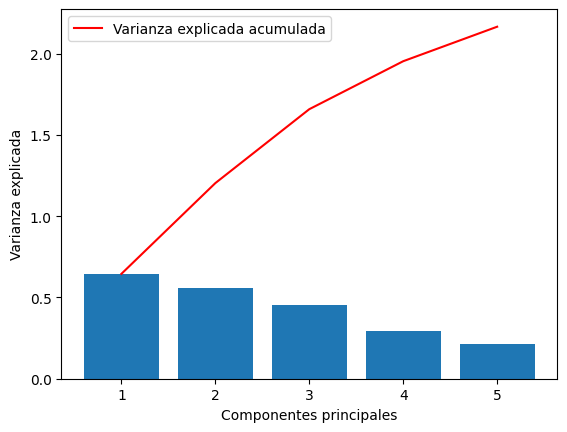

In [32]:
plt.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.ylabel('Varianza explicada')
plt.xlabel('Componentes principales')
plt.plot(range(1, len(pca.explained_variance_) + 1), np.cumsum(pca.explained_variance_),
        c='red', label="Varianza explicada acumulada")
plt.legend(loc='upper left')

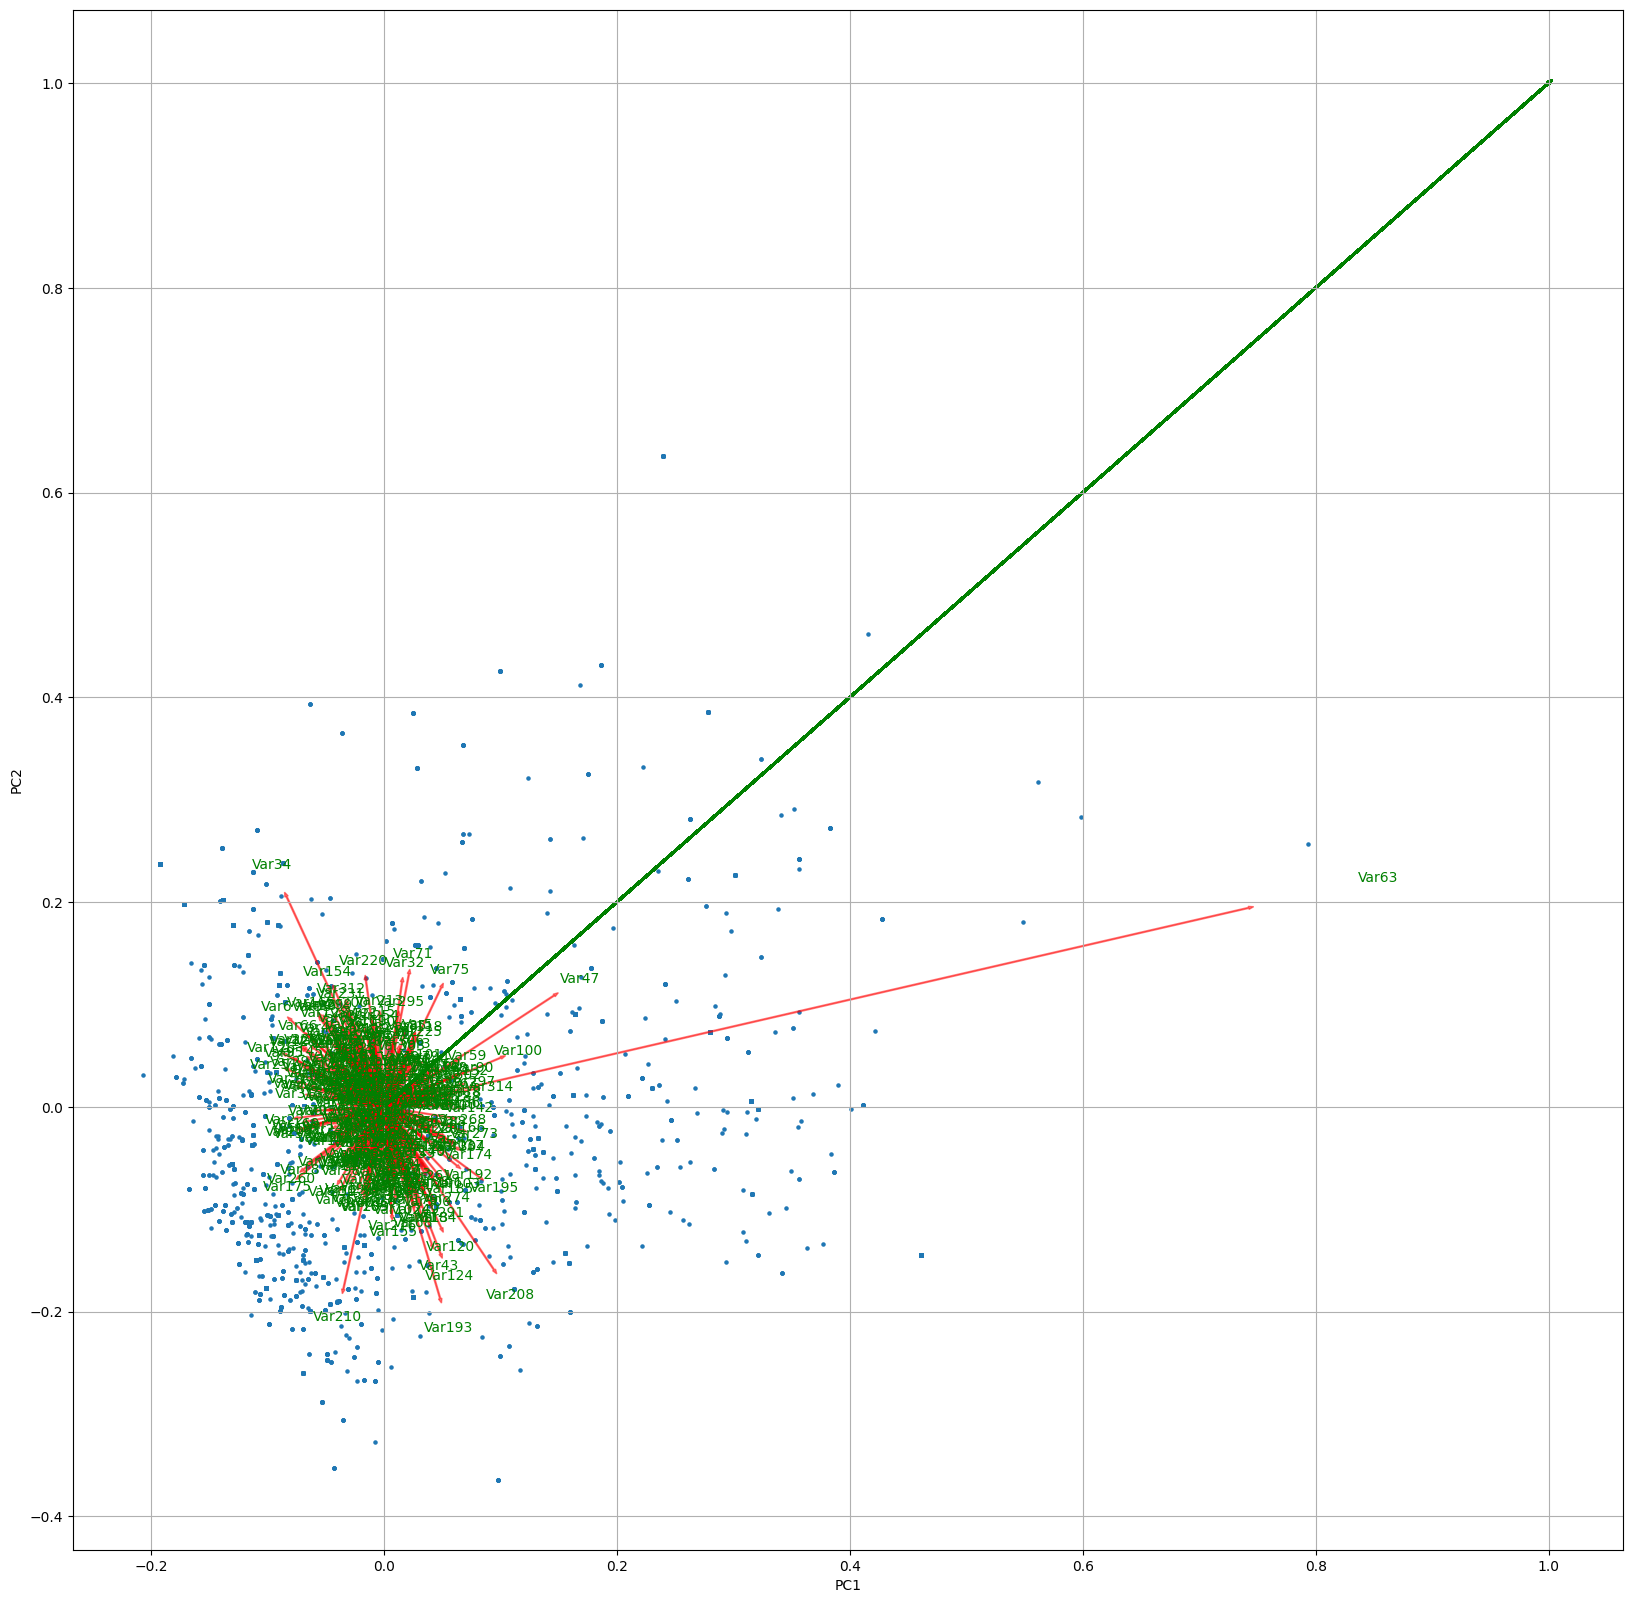

In [ ]:
def plot_pca(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.figure(figsize=[20, 20])
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0,0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i+1), color='green', ha='center', va='center')
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

plot_pca(pca_transform[:, :2], np.transpose(pca.components_[0:2, :]), labels=None)
plt.show()

In [ ]:
df_pca = pd.DataFrame(pca_transform, columns=["pca_1", "pca_2"])
df_pca["response"] = df_balanced["response"].values
df_pca.head()

In [ ]:
sns.scatterplot(data=df_pca, x="pca_1", y="pca_2", hue="response")

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(df_values)
df_tsne = pd.DataFrame(tsne, columns=["tsne_1", "tsne_2"])
df_tsne["response"] = df_balanced["response"].values
df_tsne.head()

In [ ]:
sns.scatterplot(data=df_tsne, x="tsne_1", y="tsne_2", hue="response")

## Centroid analysis

In [20]:
from scipy.spatial.distance import pdist, squareform

In [21]:
data = {
    'source': ['fuente1', 'fuente1', 'fuente2', 'fuente2'],
    'pca_1': [0.4, 0.1, 0.8, 0.2],
    'pca_2': [0.2, 0.1, 0.3, 0.2],
    'response': [1, 0, 1, 0]
}
df = pd.DataFrame(data)

In [22]:
def get_distance_by_source(group):
    coords = group[['pca_1', 'pca_2']].values
    distances = pdist(coords)

    dist_df = pd.DataFrame({
        'source': group['source'].iloc[0],
        "distance": distances
    })

    return dist_df

In [25]:
result = df.groupby("source").apply(get_distance_by_source).reset_index(drop=True)
result

/tmp/ipykernel_886377/1502038597.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby("source").apply(get_distance_by_source).reset_index(drop=True)


,source,distance
0,fuente1,0.316228
1,fuente2,0.608276


In [15]:
centroids = pd.read_csv("../data/centroids.csv")
centroids

,encoding,method,distance
0,fft_CORJ870104,pca,15.219720
1,fft_CORJ870104,tsne,14.952070
2,physicochemical_BASU050101,pca,0.311638
3,physicochemical_BASU050101,tsne,32.035905
4,physicochemical_RICJ880112,pca,1.646597
5,physicochemical_RICJ880112,tsne,16.633374
6,physicochemical_QIAN880109,pca,1.080897
7,physicochemical_QIAN880109,tsne,52.731292
8,physicochemical_PONP800105,pca,20.385600
9,physicochemical_PONP800105,tsne,11.057879


In [16]:
centroids.sort_values(by=["method", "distance"], ascending=[True, True])

,encoding,method,distance
14,esm2_t6_8M_UR50D,pca,0.154743
30,Mistral-Prot-v1-15M,pca,0.212467
2,physicochemical_BASU050101,pca,0.311638
12,physicochemical_VENT840101,pca,0.370601
6,physicochemical_QIAN880109,pca,1.080897
28,physicochemical_CORJ870104,pca,1.600822
4,physicochemical_RICJ880112,pca,1.646597
24,one_hot,pca,1.721499
38,physicochemical_RACS820101,pca,1.994385
18,physicochemical_WOLS870103,pca,2.469925


In [33]:
sorted_centroids = centroids.sort_values(by=["method", "distance"], ascending=[False, False])
sorted_centroids["distance"] = sorted_centroids["distance"].apply(lambda x: f"{x:.2f}")
sorted_centroids["encoding"] = sorted_centroids["encoding"].apply(lambda x: x.replace("_", " "))
print(sorted_centroids[sorted_centroids["method"] == "pca"].head(5).drop(columns="method").to_latex(index=False))

\begin{tabular}{ll}
\toprule
encoding & distance \\
\midrule
fft PONP800105 & 427.24 \\
fft OOBM850104 & 235.67 \\
fft ROSM880101 & 203.83 \\
fft WOLS870103 & 53.98 \\
fft RICJ880112 & 47.26 \\
\bottomrule
\end{tabular}

